# 2. Graphical monitoring and overfitting

## Regression example: California Housing

Let us consider now how a regression problem can be analyzed with a neural network model. First, we introduce some useful imports, and download a new dataset for this purpose.

In [122]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import california_housing

(inputs, targets), (x_test, y_test) = california_housing.load_data(version='small', test_split=0.2)
print(inputs.shape, x_test.shape)
print(targets.shape, y_test.shape)

(480, 8) (120, 8)
(480,) (120,)


Extract a part of the inputs and targets for validation, and the rest for training.

In [123]:
x_train = inputs[:380]
y_train = targets[:380]
x_val = inputs[380:]
y_val = targets[380:]

Next, we standardize the input features; note that only the training set is used to compute the mean and standard deviation used in normalizing. Also, we divide the target variable (house prize in dollars) by 100000, in order to obtain values on the order of unity.

In [124]:
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)
x_train -= mean
x_train /= std
x_test -= mean
x_test /= std
x_val -= mean
x_val /= std
y_train /= 1e5
y_test /= 1e5
y_val /= 1e5

In the cell below, a simple model with two fully connected hidden layers with ReLU activation is built. Note that the output layer only contains a single unit for outputting the prediction for the prize, and no activation function is used (the model is able to output any value without restrictions). The appropriate loss function for a regression problem is mean squared error (MSE), and the mean average error (MAE) is chosen as the metric to be monitored.

In [168]:
import tensorflow as tf
model = Sequential([
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(1)
    ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),loss='mse',metrics=['mae'])

Next, we train the model for 400 epochs, with the validation set extracted above. The zero value for the verbose parameter suppresses the outputs during training. Instead, we use the History object returned by the fit method to access the information about training progress.

In [169]:
history = model.fit(x_train, y_train, epochs=400, batch_size=32, validation_data=(x_val, y_val),    verbose=0)

The History object contains a dictionary `history`, whose keys can be used to access arrays containing the recorded metrics after each epoch. Using Matplotlib, we can e.g. take a look at loss values during training both for the training set and validation set as follows (note that first ten epochs are discarded for clearer visualization): 

Text(0, 0.5, 'Loss')

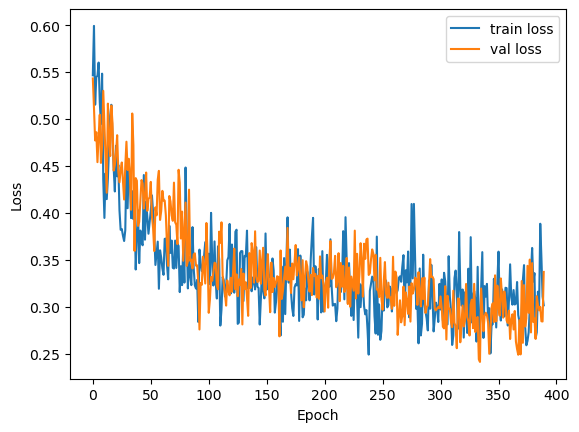

In [170]:
plt.plot(history.history['loss'][10:], label='train loss')
plt.plot(history.history['val_loss'][10:], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

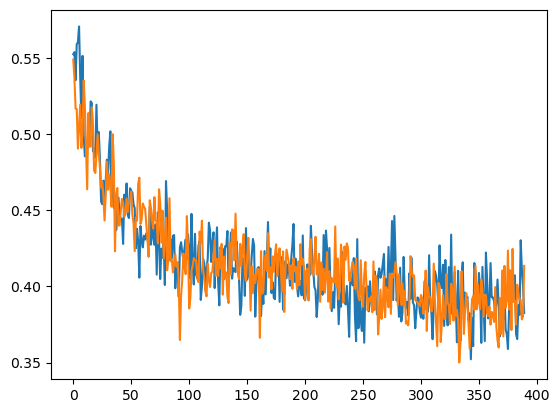

In [171]:
plt.plot(history.history['mae'][10:])
plt.plot(history.history['val_mae'][10:])

In [172]:
test_loss, test_mae = model.evaluate(x_test, y_test)
print(f'Test mean average error: {test_mae}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4576 - mae: 0.3843 
Test mean average error: 0.3927527964115143
